<a href="https://colab.research.google.com/github/d3rar/Deep_Reinforcement_Learning/blob/main/2024_Challenge_RL_PolicyGradients_PPO_Continuous_Exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Reinforcement Lerning Lectures - Policy Gradients

### Imports and auxiliary settings

In [1]:
!apt update
!apt install -y xvfb x11-utils python3-opengl ffmpeg swig
!pip install swig
!pip install jax==0.4.13 jaxlib==0.4.13
!pip install gymnasium==0.27.1 gymnasium[box2d] pyvirtualdisplay imageio-ffmpeg moviepy==1.0.3
!pip install onnx onnx2pytorch==0.4.1
!pip install numpy==2.0.2

Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:6 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:8 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:9 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [2,901 kB]
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [8,932 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:13 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Package

In [ ]:
!pip install --upgrade --force-reinstall "numpy==1.26.4"
import os
os.kill(os.getpid(), 9)  # force Colab runtime restart


os.environ["CUDA_VISIBLE_DEVICES"] = "0"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 115.3 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
chex 0.1.89 requires jax>=0.4.27, but you have jax 0.4.13 which is incompatible.
chex 0.1.89 requires jaxlib>=0.4.27, but you have jaxlib 0.4.13 which is incompatible.
flax 0.10.6 requires jax>=0.5.1, but you have jax 0.4.13 which is incompatible.
dopamine-rl 4.1.2 requires gymnasium>=1.0.0, but you have gymnasium 0.27.1 which is incompatible.
orbax-checkpoint 0.11.13 requires jax>=0.5.0, but you have jax 0.4.13 which is i

In [ ]:
# select device
#import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [1]:
%matplotlib inline

# PyTorch imports
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal
from torch.utils.data import Dataset, DataLoader

# Cross Framework library for DL
import onnx
from onnx2pytorch import ConvertModel

# Auxiliary Python imports
import os
import math
import io
import base64
import random
import shutil
import copy
import glob
from time import time, strftime
from tqdm import tqdm
import numpy as np
from tqdm.notebook import tqdm
from time import sleep

# Environment import and set logger level to display error only
# Environment import and set logger level to display error only
import gymnasium as gym
from gymnasium.spaces import Box
from gymnasium import logger as gymlogger
from gymnasium.wrappers import RecordVideo
gymlogger.set_level(gym.logger.ERROR)

# Plotting and notebook imports
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from IPython.display import HTML, display, clear_output

# start virtual display
from pyvirtualdisplay import Display
pydisplay = Display(visible=0, size=(640, 480))
pydisplay.start()

ERROR:jax._src.xla_bridge:Jax plugin configuration error: Plugin module %s could not be loaded
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/jax/_src/xla_bridge.py", line 420, in discover_pjrt_plugins
    plugin_module = importlib.import_module(plugin_module_name)
                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/importlib/__init__.py", line 126, in import_module
    return _bootstrap._gcd_import(name[level:], package, level)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<frozen importlib._bootstrap>", line 1204, in _gcd_import
  File "<frozen importlib._bootstrap>", line 1176, in _find_and_load
  File "<frozen importlib._bootstrap>", line 1147, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 690, in _load_unlocked
  File "<frozen importlib._bootstrap_external>", line 940, in exec_module
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_r

In [2]:
# use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Auxiliary Methods

In [3]:

class Logger(object):
    """Logger that can be used for debugging different values."""
    def __init__(self, logdir, params=None, debug=False):
        self.gradients = []
        self.debug = debug
        self.basepath = os.path.join(logdir, strftime("%Y-%m-%dT%H-%M-%S"))
        self._log_dir = os.path.join(self.basepath, "logs")
        os.makedirs(self.basepath, exist_ok=True)
        os.makedirs(self._log_dir, exist_ok=True)

        if params is not None and os.path.exists(params):
            shutil.copyfile(params, os.path.join(self.basepath, "params.pkl"))

        self.log_dict = {}
        self.dump_idx = {}

    def add_gradients(self, grad):
        if not self.debug:
            return
        self.gradients.append(grad)

    def compute_gradient_variance(self):
        vars_ = []
        grads_list = [np.zeros_like(self.gradients[0])] * 100
        for i, grads in enumerate(self.gradients):
            grads_list.append(grads)
            grads_list = grads_list[1:]
            grad_arr = np.stack(grads_list, axis=0)
            g = np.apply_along_axis(self._grad_variance, axis=-1, arr=grad_arr)
            vars_.append(np.mean(g))
        return vars_

    def _grad_variance(self, g):
        return np.mean(g**2) - np.mean(g)**2

    @property
    def param_file(self):
        return os.path.join(self.basepath, "params.pkl")

    @property
    def onnx_file(self):
        return os.path.join(self.basepath, "model.onnx")

    @property
    def video_dir(self):
        return os.path.join(self.basepath, "videos")

    @property
    def log_dir(self):
        return self._log_dir

    def log(self, name, value):
        if name not in self.log_dict:
            self.log_dict[name] = []
            self.dump_idx[name] = -1
        self.log_dict[name].append((len(self.log_dict[name]), time(), value))

    def get_values(self, name):
        if name in self.log_dict:
            return [x[2] for x in self.log_dict[name]]
        return None

    def dump(self):
        for name, rows in self.log_dict.items():
            safe_name = name.replace("/", "_")
            with open(os.path.join(self.log_dir, safe_name + ".log"), "a") as f:
                for i, row in enumerate(rows):
                    if i > self.dump_idx[name]:
                        f.write(",".join([str(x) for x in row]) + "\n")
                        self.dump_idx[name] = i


In [9]:
def wrap_env(env, logger, capture_video=True):
    # wrapper for recording
    env = gym.wrappers.RecordEpisodeStatistics(env)
    if capture_video:
        env = gym.wrappers.RecordVideo(env, logger.video_dir, episode_trigger=lambda idx: True)
    return env


def create_env(logger, env_id='BipedalWalker-v3', hardcore=False, capture_video=True):
    # initialize environment
    env = wrap_env(gym.make(env_id, max_episode_steps=400, hardcore=hardcore, render_mode="rgb_array"),
                   logger=logger,
                   capture_video=capture_video)
    action_size = env.action_space.shape[0]
    state_size = env.observation_space.shape[0]
    return env, action_size, state_size


def set_seed(env, seed=None):
    # seeding the envrionment
    if seed is not None:
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed(seed)
            torch.cuda.manual_seed_all(seed)


def transforms(state):
    # transofrm to numpy to tensor and push to device
    return torch.FloatTensor(state).to(device)


def test_environment(env, agent=None, seed=42, n_steps=200):
    # run and evaluate in the environment
    state, info = env.reset(seed=seed)
    for i in range(n_steps):
        env.render()

        if agent is None:
            action = env.action_space.sample()
        else:
            action, _ = agent.act(state)
            action = action.squeeze().cpu().numpy()
        state, reward, done, truncated, info = env.step(action)
        if done:
            state, info = env.reset(seed=seed)
    env.close()


def get_running_stat(stat, stat_len):
    # evaluate stats
    cum_sum = np.cumsum(np.insert(stat, 0, 0))
    return (cum_sum[stat_len:] - cum_sum[:-stat_len]) / stat_len


def plot_results(runner):
    # plot stats
    episode, r, l = np.array(runner.stats_rewards_list).T
    cum_r = get_running_stat(r, 10)
    cum_l = get_running_stat(l, 10)

    plt.figure(figsize=(16, 16))

    plt.subplot(321)

    # plot rewards
    plt.plot(episode[-len(cum_r):], cum_r)
    plt.plot(episode, r, alpha=0.5)
    plt.xlabel('Episode')
    plt.ylabel('Episode Reward')

    plt.subplot(322)

    # plot episode lengths
    plt.plot(episode[-len(cum_l):], cum_l)
    plt.plot(episode, l, alpha=0.5)
    plt.xlabel('Episode')
    plt.ylabel('Episode Length')

    plt.subplot(323)

    # plot return
    all_returns = np.array(runner.buffer.all_returns)
    plt.scatter(range(0, len(all_returns)), all_returns, alpha=0.5)
    mean_returns = np.array(runner.buffer.mean_returns)
    plt.plot(range(0, len(mean_returns)), mean_returns, color="orange")
    plt.xlabel('Episode')
    plt.ylabel('Return')

    plt.subplot(324)

    # plot entropy
    entropy_arr = np.array(runner.stats_entropy_list)
    plt.plot(range(0, len(entropy_arr)), entropy_arr)
    plt.xlabel('Episode')
    plt.ylabel('Entropy')

    plt.subplot(325)

    if runner.logger.debug:
        # plot variance
        variance_arr = np.array(runner.logger.compute_gradient_variance())
        plt.plot(range(0, len(variance_arr)), variance_arr)
        plt.xlabel('Episode')
        plt.ylabel('Variance')

    plt.show()


"""
Utility functions to enable video recording of gym environment and displaying it
"""
def show_video(logger):
    print(logger.video_dir)
    mp4list = glob.glob(f'{logger.video_dir}/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        display(HTML(data='''<video alt="test" autoplay
                  loop controls style="height: 400px;">
                  <source src="data:video/mp4;base64,{0}" type="video/mp4" />
                </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")


def grad_variance(g):
    # compute gradient variance
    return np.mean(g**2) - np.mean(g)**2

### Test environment

OpenAI offers a set of environments for Reinforcement Learning, which are accessible via the `gymnasium` pip package.
In this exercise we will focus on discrete control tasks using a Box2D simulation known as BipedalWalker-v3.
To access the Box2D packages, we use the gymnasium pypi `box2d` option.

In [10]:
# show behavior in envrionment with random agent
logger = Logger("logdir")
env, _, _ = create_env(logger)
test_environment(env)
show_video(logger)

Moviepy - Building video /content/logdir/2025-05-14T07-37-25/videos/rl-video-episode-0.mp4.
Moviepy - Writing video /content/logdir/2025-05-14T07-37-25/videos/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/logdir/2025-05-14T07-37-25/videos/rl-video-episode-0.mp4
Moviepy - Building video /content/logdir/2025-05-14T07-37-25/videos/rl-video-episode-1.mp4.
Moviepy - Writing video /content/logdir/2025-05-14T07-37-25/videos/rl-video-episode-1.mp4



Moviepy - Done !
Moviepy - video ready /content/logdir/2025-05-14T07-37-25/videos/rl-video-episode-1.mp4
Moviepy - Building video /content/logdir/2025-05-14T07-37-25/videos/rl-video-episode-2.mp4.
Moviepy - Writing video /content/logdir/2025-05-14T07-37-25/videos/rl-video-episode-2.mp4



Moviepy - Done !
Moviepy - video ready /content/logdir/2025-05-14T07-37-25/videos/rl-video-episode-2.mp4
logdir/2025-05-14T07-37-25/videos


### Training Buffer

In [ ]:
class Transition(object):
    """Transition helper object
    """
    def __init__(self, state, action, reward, next_state, log_probs):
        self.state = state
        self.action = action
        self.reward = reward
        self.next_state = next_state
        self.g_return = 0.0
        self.log_probs = log_probs


class Episode(object):
    """Class for collecting an episode of transitions
    """
    def __init__(self, discount):
        self.discount = discount
        self._empty()
        self.total_reward = 0.0

    def _empty(self):
        self.n = 0
        self.transitions = []

    def reset(self):
        self._empty()

    def size(self):
        return self.n

    def append(self, transition):
        self.transitions.append(transition)
        self.n += 1

    def states(self):
        return [s.state for s in self.transitions]

    def actions(self):
        return [a.action for a in self.transitions]

    def rewards(self):
        return [r.reward for r in self.transitions]

    def next_states(self):
        return [s_.next_state for s_ in self.transitions]

    def returns(self):
        return [r.g_return for r in self.transitions]

    def calculate_return(self):
        # calculate the return of the episode
        rewards = self.rewards()
        trajectory_len = len(rewards)
        return_array = torch.zeros((trajectory_len,))
        g_return = 0.
        for i in range(trajectory_len-1, -1, -1):
            g_return = rewards[i] + self.discount*g_return
            return_array[i] = g_return
            self.transitions[i].g_return = g_return
        return return_array


class BufferDataset(Dataset):
    """Buffer dataset used to iterate over buffer samples when training.
    """
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        t = self.data[idx]
        return t.state, t.action, t.reward, t.next_state, t.log_probs


class RolloutBuffer(object):
    # ===================================================
    # ++++++++++++++++++++ OPTIONAL +++++++++++++++++++++
    # ===================================================
    # > feel free to optimize sampling and buffer handling
    # ===================================================
    """Buffer to collect samples while rolling out in the envrionment.
    """
    def __init__(self, capacity, batch_size, min_transitions):
        self.capacity = capacity
        self.batch_size = batch_size
        self.min_transitions = min_transitions
        self.buffer = []
        self._empty()
        self.mean_returns = []
        self.all_returns = []

    def _empty(self):
        # empty the buffer
        del self.buffer[:]
        self.position = 0

    def add(self, episode):
        # Saves a transition
        episode.calculate_return()
        for t in episode.transitions:
            if len(self.buffer) < self.capacity:
                self.buffer.append(None)
            self.buffer[self.position] = t
            self.position = (self.position + 1) % self.capacity

    def update_stats(self):
        # update the statistics on the buffer
        returns = [t.g_return for t in self.buffer]
        self.all_returns += returns
        mean_return = np.mean(np.array(returns))
        self.mean_returns += ([mean_return]*len(returns))

    def reset(self):
        # calls empty
        self._empty()

    def create_dataloader(self):
        # creates a dataloader for training
        train_loader = DataLoader(
            BufferDataset(self.buffer),
            batch_size=self.batch_size,
            shuffle=True
        )
        return train_loader

    def __len__(self):
        return len(self.buffer)

### Define Models

In [ ]:
class ActorNet(nn.Module):
    """Actor network (policy)
    """
    def __init__(self, state_size, action_size, hidden_size):
        super(ActorNet, self).__init__()
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.mu = nn.Linear(hidden_size, action_size)
        self.sigma = nn.Linear(hidden_size, action_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        mu_logits = self.mu(x)
        sigma_logits = self.sigma(x)
        return mu_logits, sigma_logits

class CriticNet(nn.Module):
    """Critic network computing the state value
    """
    def __init__(self, state_size, action_size, hidden_size):
        super(CriticNet, self).__init__()
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.value_out = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        value = self.value_out(x)
        return value

class ActorCriticNet(nn.Module):
    """Combining both networks and add helper methods to act and evaluate samples.
    """
    def __init__(self, state_size, action_size, hidden_size):
        super(ActorCriticNet, self).__init__()
        self.actor = ActorNet(state_size, action_size, hidden_size)
        self.critic = CriticNet(state_size, action_size, hidden_size)

    def forward(self, x):
        x = x.reshape(1, -1)
        return self.act(x)

    def act(self, state):
        mu_logits, sigma_logits = self.actor(state)
        sigma = F.softplus(sigma_logits) + 1e-5  # Ensure positive with epsilon
        dist = Normal(mu_logits, sigma)
        action = dist.sample()
        log_prob = dist.log_prob(action).sum(-1, keepdim=True)
        return action, log_prob

    def evaluate(self, state, action):
        mu_logits, sigma_logits = self.actor(state)
        sigma = F.softplus(sigma_logits) + 1e-5
        dist = Normal(mu_logits, sigma)
        log_prob = dist.log_prob(action).sum(-1, keepdim=True)
        entropy = dist.entropy().sum(-1, keepdim=True)
        value = self.critic(state)
        return log_prob, entropy, value

### Define Agent

In [ ]:
class Agent(object):
    """Agent class used for training, saving data and handling the model."""
    def __init__(self, buffer, state_size, action_size, hidden_size, learning_rate, logger, eps_clip, n_epochs,
                 weight_decay, betas, loss_scales, discount, checkpoint_dir="ckpts"):
        self.action_size = action_size
        self.state_size = state_size
        self.buffer = buffer
        self.checkpoint_dir = checkpoint_dir
        self.loss_scales = loss_scales
        self.n_epochs = n_epochs
        self.eps_clip = eps_clip
        self.logger = logger
        self.discount = discount

        self.model = ActorCriticNet(state_size, action_size, hidden_size).to(device)
        self.optimizer = optim.Adam(self.model.parameters(),
                                    lr=learning_rate,
                                    weight_decay=weight_decay,
                                    betas=betas)

    def save_checkpoint(self, epoch, info=''):
        state = {
            'info': info,
            'epoch': epoch,
            'state_dict': self.model.state_dict(),
            'optimizer': self.optimizer.state_dict()
        }
        os.makedirs(self.checkpoint_dir, exist_ok=True)
        name = 'best-checkpoint.pth' if info == 'best' else f'checkpoint-epoch{epoch}.pth'
        torch.save(state, os.path.join(self.checkpoint_dir, name))

    def resume_checkpoint(self, resume_path):
        print(f"Loading checkpoint: {resume_path} ...")
        checkpoint = torch.load(resume_path)
        self.model.load_state_dict(checkpoint['state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer'])
        print("Checkpoint loaded.")

    def load_onnx_checkpoint(self, onnx_file):
        self.model.actor = ConvertModel(onnx.load(onnx_file)).to(device)
        self.model.eval()

    def save_onnx_checkpoint(self):
        dummy_input = torch.randn((1, self.state_size)).to(device)
        torch.onnx.export(self.model.actor, dummy_input, "submission_actor.onnx", opset_version=10,
                          export_params=True, do_constant_folding=True)

    def check(self, file_name):
        model = onnx.load(file_name)
        onnx.checker.check_model(model)

    def act(self, state):
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        with torch.no_grad():
            action, log_prob = self.model.act(state)
        return action.squeeze(0).cpu().numpy(), log_prob.squeeze(0).cpu().numpy()

    def train(self):
        for _ in range(self.n_epochs):
            loader = self.buffer.create_dataloader()
            for states, actions, rewards, next_states, old_log_probs in loader:
                # Force float32 everywhere
                states = states.float().to(device)
                actions = actions.float().to(device)
                rewards = rewards.float().unsqueeze(-1).to(device)
                next_states = next_states.float().to(device)
                old_log_probs = old_log_probs.float().to(device)

                # Target value from next state
                with torch.no_grad():
                    next_values = self.model.critic(next_states)
                    target_values = rewards + self.discount * next_values

                current_values = self.model.critic(states)
                advantages = target_values - current_values.detach()

                log_probs, entropy, values = self.model.evaluate(states, actions)
                ratios = torch.exp(log_probs - old_log_probs)

                surr1 = ratios * advantages
                surr2 = torch.clamp(ratios, 1 - self.eps_clip, 1 + self.eps_clip) * advantages
                policy_loss = -torch.min(surr1, surr2).mean()
                value_loss = F.mse_loss(values, target_values)

                total_loss = (
                    self.loss_scales[0] * policy_loss +
                    self.loss_scales[1] * value_loss -
                    self.loss_scales[2] * entropy.mean()
                )

                self.optimizer.zero_grad()
                total_loss.backward()
                self.optimizer.step()

        return (
            total_loss.item(),
            value_loss.item(),
            policy_loss.item()
        ), entropy.mean().item()


### Define Task Runner

In [ ]:
class Runner(object):
    """Runner class performing the rollout in the environment and calling the agent training function periodically"""
    def __init__(self, env, agent, buffer, logger, discount=0.99, n_episodes=4000, reward_scale=lambda x: x,
                 use_buffer_reset=True, stats_interval=1, print_stats=True, min_average_reward=300, render=False,
                 seed=42, checkpoint_interval=100, max_episode_steps=2000):
        self.env = env
        self.agent = agent
        self.buffer = buffer
        self.render = render
        self.logger = logger
        self.discount = discount
        self.n_episodes = n_episodes
        self.reward_scale = reward_scale
        self.use_buffer_reset = use_buffer_reset
        self.stats_interval = stats_interval
        self.print_stats = print_stats
        self.min_average_reward = min_average_reward
        self.seed = seed
        self.max_episode_steps = max_episode_steps
        self.stats_rewards_list = []
        self.stats_entropy_list = []
        self.timesteps = 0
        self.checkpoint_interval = checkpoint_interval
        self.best_model = None
        self.max_reward = -np.inf

    def run(self):
        self.agent.model.eval()
        with tqdm(range(self.n_episodes)) as pbar:
            for e in pbar:
                state, info = self.env.reset(seed=self.seed)
                total_losses = 0.
                value_losses = 0.
                policy_losses = 0.
                episode = Episode(discount=self.discount)

                if e % self.checkpoint_interval == 0:
                    self.agent.save_checkpoint(e)

                done = False
                while not done:
                    self.timesteps += 1
                    if self.render:
                        self.env.render()

                    state_tensor = torch.FloatTensor(state).unsqueeze(0)
                    with torch.no_grad():
                        action_tensor, log_prob = self.agent.act(state_tensor)

                    if isinstance(action_tensor, torch.Tensor):
                        action = action_tensor.squeeze().cpu().numpy()
                    else:
                        action = np.squeeze(action_tensor)

                    next_state, reward, terminated, truncated, _ = self.env.step(action)
                    done = terminated or truncated
                    scaled_reward = self.reward_scale(reward)

                    # Store in episode
                    transition = Transition(
                        state=torch.FloatTensor(state),
                        action=torch.FloatTensor(action),
                        reward=scaled_reward,
                        next_state=torch.FloatTensor(next_state),
                        log_probs=torch.tensor(log_prob).detach() if isinstance(log_prob, np.ndarray) else log_prob.detach()
                    )
                    episode.append(transition)
                    episode.total_reward += reward

                    # Train if buffer is ready
                    if len(self.buffer) >= self.buffer.batch_size:
                        losses, entropy = self.agent.train()
                        self.buffer.update_stats()
                        total_losses += losses[0]
                        value_losses += losses[1]
                        policy_losses += losses[2]
                        self.logger.log("Loss/Total", losses[0])
                        self.logger.log("Loss/Value", losses[1])
                        self.logger.log("Loss/Policy", losses[2])
                        self.logger.log("Entropy", entropy)
                        if self.use_buffer_reset:
                            self.buffer.reset()

                    state = next_state

                # Add completed episode to buffer
                self.buffer.add(episode)

                episode_reward = episode.total_reward
                self.stats_rewards_list.append((e, episode_reward, episode.size()))
                self.stats_entropy_list.append(entropy if 'entropy' in locals() else 0)

                # Save best model
                if episode_reward > self.max_reward:
                    self.max_reward = episode_reward
                    self.best_model = copy.deepcopy(self.agent.model)
                    self.agent.save_checkpoint(e, 'best')

                # Logging
                self.logger.log("EpisodeReward", episode_reward)
                self.logger.dump()


### Train Agent

This is a where you run your actor-critic PPO algorithm.

Some tips as to what you need to implement:
- chose proper architectures for the actor-critic networks
- choose the appropriate loss function (think on which kind of problem you are solving)
- choose an optimizer and its hyper-parameters
- optional: use a learning-rate scheduler
- store your model and training progress often so you don't loose progress if your program crashes

In case you use the provided Logger:
- `logger.log("training_loss", <loss-value>)` to log a particular value
- `logger.dump()` to write the current logs to a log file (e.g. after every episode)
- `logger.log_dir`, `logger.param_file`, `logger.onnx_file`, `logger.video_dir` point to files or directories you can use to save files
- you might want to specify your google drive folder as a logdir in order to automatically sync your results
- if you log the metrics specified in the `plot_metrics` function you can use it to visualize your training progress (or take it as a template to plot your own metrics)

  0%|          | 0/10000 [00:00<?, ?it/s]

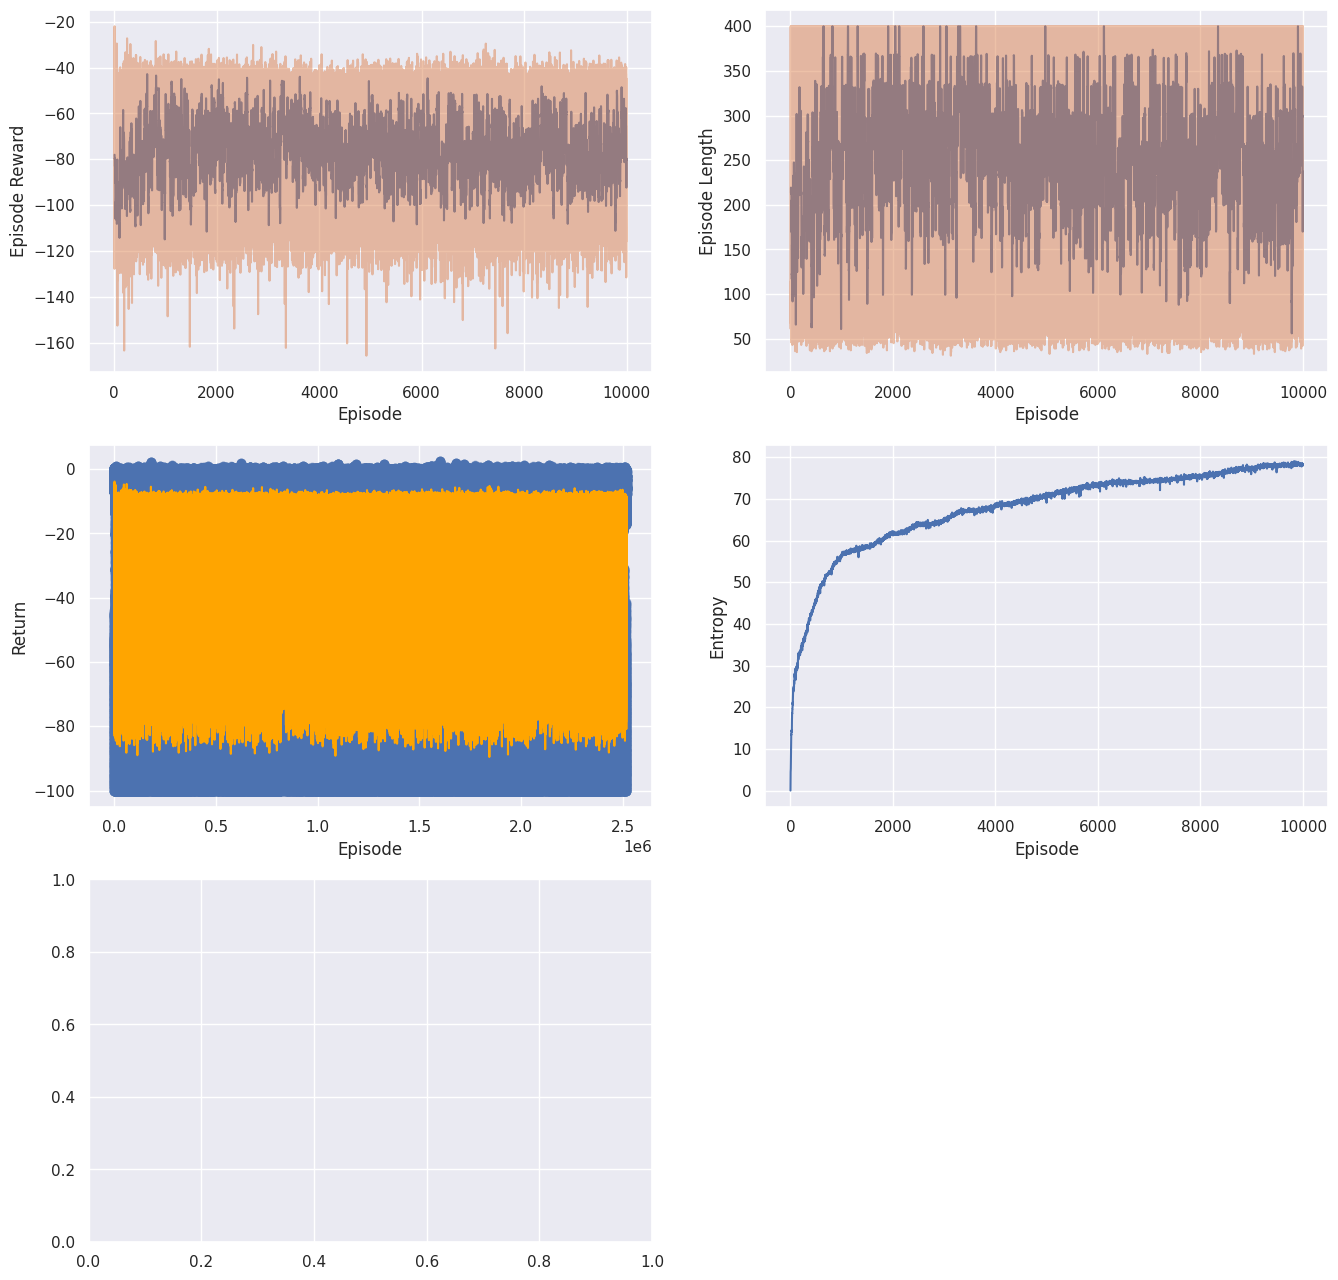

In [ ]:
# create environment
logger = Logger("logdir")
env, action_size, state_size = create_env(logger, capture_video=False)

seed = 31
# set seed
set_seed(env, seed=seed)

# hyperparameters
episodes = 10000
epochs = 4
hidden_size = 256
learning_rate = 3e-4
discount = 0.99
reward_scale = lambda x: x

batch_size = 64
min_transitions = 1000
capacity = 50000

use_buffer_reset = True
eps_clip = 0.2
loss_scales = (1.0, 0.5, 0.01)  # (policy, value, entropy)
betas = (0.9, 0.999)
weight_decay = 0.0
checkpoint_interval = 100

# additional settings
print_stats = True
render = False

# build agent and runner
buffer = RolloutBuffer(capacity=capacity, batch_size=batch_size, min_transitions=min_transitions)
agent = Agent(buffer=buffer,
              state_size=state_size,
              action_size=action_size,
              hidden_size=hidden_size,
              learning_rate=learning_rate,
              logger=logger,
              eps_clip=eps_clip,
              n_epochs=epochs,
              weight_decay=weight_decay,
              betas=betas,
              loss_scales=loss_scales,
              discount=discount)

runner = Runner(env=env,
                agent=agent,
                buffer=buffer,
                logger=logger,
                discount=discount,
                n_episodes=episodes,
                reward_scale=reward_scale,
                use_buffer_reset=use_buffer_reset,
                print_stats=print_stats,
                render=render,
                seed=seed,
                checkpoint_interval=checkpoint_interval)

# === TRAIN ===
runner.run()
plot_results(runner)
agent.save_onnx_checkpoint()


In [ ]:
buffer = RolloutBuffer(capacity=capacity, batch_size=batch_size, min_transitions=min_transitions)
agent = Agent(buffer=buffer, state_size=state_size, action_size=action_size, hidden_size=hidden_size,
              learning_rate=learning_rate, logger=logger, eps_clip=eps_clip, n_epochs=epochs, weight_decay=weight_decay, betas=betas, loss_scales=loss_scales, discount=discount)
runner = Runner(env=env, agent=agent, buffer=buffer, logger=logger, discount=discount, n_episodes=episodes, reward_scale=reward_scale,
                use_buffer_reset=use_buffer_reset, print_stats=print_stats, render=render, seed=seed)

In [ ]:
runner.run()

  0%|          | 0/10000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
plot_results(runner)

In [ ]:
agent.save_onnx_checkpoint()

## Visualize Agent

In [ ]:
# load model from checkpoint
agent.resume_checkpoint('ckpts/best-checkpoint.pth')

In [ ]:
# run agent in the envrionment
env, _, _ = create_env(logger)
agent.model.eval()
test_environment(env=env, agent=agent)
show_video(logger)

# Demo Evaluations

In [ ]:
agent.load_onnx_checkpoint('demo.onnx')

In [ ]:
# run agent in the envrionment
logger = Logger('logdir')
env, _, _ = create_env(logger)
agent.model.eval()
test_environment(env=env, agent=agent, n_steps=500)
show_video(logger)